# Exercise 2 - Multi-class text classification Problem

GOAL: Use Supervised Machine Learning Methods and NLP to build a model that classifies new incoming "user complains" into one of the product categories.
      Target variable: Product
      Feature: "Consumer complaint narrative"

EXERCISE: 
    - Preprocess the dataset
    - Use TF-IDF for Text Representation
    - Using hte Naive Bayes implementation as a guidance, apply other classification models to the problem.
    - Evaluate all the model used and identify the best one

NB: please notice that the TfidVectorized will not run locally on the whole dataset. The exercise will be presented on a subsample of 5000 rows

# Walkthrough

#### Data Exploration
     - cutting dataset
#### Data Cleaning
     - checking for class imbalances
#### Text Representation
    - TF-IDF
    - Finding terms correlations
#### Classifier Implementation ( Naive Bayes)
#### Multiple Model Implementation 
#### Benchmarking and Evaluation

### DATA EXPLORATION

In [2]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
df.head(3)

/Users/mousadak/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,12/31/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"Convergent Resources, Inc.",GA,NaN,NaN,NaN,Web,12/31/2018,Closed with explanation,Yes,NaN,3113161
1,12/31/2018,Vehicle loan or lease,Lease,Managing the loan or lease,Problem with fees charged,NaN,NaN,MERCEDES BENZ FINANCIAL SERVICES,CA,NaN,NaN,Other,Web,12/31/2018,In progress,Yes,NaN,3113131
2,12/31/2018,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,"BCA Financial Services, Inc.",FL,336XX,NaN,NaN,Web,12/31/2018,In progress,Yes,NaN,3113586


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189771 entries, 0 to 1189770
Data columns (total 18 columns):
Date received                   1189771 non-null object
Product                         1189771 non-null object
Sub-product                     954605 non-null object
Issue                           1189771 non-null object
Sub-issue                       670648 non-null object
Consumer complaint narrative    354576 non-null object
Company public response         402196 non-null object
Company                         1189771 non-null object
State                           1173147 non-null object
ZIP code                        1091506 non-null object
Tags                            162567 non-null object
Consumer consent provided?      627943 non-null object
Submitted via                   1189771 non-null object
Date sent to company            1189771 non-null object
Company response to consumer    1189765 non-null object
Timely response?                1189771 non-null obje

In [4]:
#Running the exercise on the first 5000 rows
###########
    # previous code
    #df = df.head(5000)
###########    
    # new code with random sample
df = df.sample(frac = 0.01)

### DATA CLEANING

In [5]:
#TO DO: Identify the target and the feature columns

In [6]:
#TO DO: Clean the columns (removing missing values)
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
89325,Debt collection,Help : i keep getting harassing letters from c...,0
47806,Vehicle loan or lease,My car loan was with XXXX XXXX in New Jersey. ...,1
283001,Checking or savings account,I was solicited by Capital One 360 to open a C...,2
505890,Credit card,In XX/XX/XXXX I borrowed {$45000.00} on my XXX...,3
85657,Credit card or prepaid card,Walmart Master Card Interest Rate : I called W...,4


#### Checking for class imbalances
- TO DO: visualize the category frequency in the dataset 
NB: NO RESAMPLING METHOD IS IMPLEMENTED

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)


In the image above we see that classes are highly imbalanced. Though we are continuing the exercises as such classes should be balanced before running machine learning. You are recommend to read the documentation of __up/downsampling__ in python
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

#### Text Representation

Raw text cannot be used for classification purposes. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
#TO DO: Implement the TfidVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id


In [9]:
features.shape
# Now, each of 525 consumer complaint narratives is represented by 1582 features, representing the tf-idf score for different unigrams and bigrams.

(3612, 10618)

#### Fearture selection using Chi2 test
chi-square test can be used to select a subste of features that show a difference between 
categories. A statistician might not prefer this but, let's stick to what engineers do to reduce the dimentions of the data. Chi2 provides chi-sq statistics and p-val for all featues in form of two lists. One can either use p-value (__p_val_threshold__) or by selecting a subset of features (__N__ in the code below). Both ways of selection is shown here.

In [10]:
#using sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products

from sklearn.feature_selection import chi2
import numpy as np
N = 2
# our p-value cut-off
p_val_threshold = 0.1
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
###########
    #original code
#    indices = np.argsort(features_chi2[0])  
###########
########### selecting using p-value cutoff
# Modified code
    indices = []
    for i in range(0, len(features_chi2[1])):
        if(features_chi2[1][i] <= p_val_threshold):
            indices.append(i)
###########            
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
########### selecting using top N chi-sq performing features
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. wells
. wellsfargo
  . Most correlated bigrams:
. xxxx overdraft
. xxxx transactions
# 'Checking or savings account':
  . Most correlated unigrams:
. withdrawals
. withdrew
  . Most correlated bigrams:
. xxxx meeting
. xxxx merchant
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. wear
  . Most correlated bigrams:
. xxxx financed
. xxxx vehicle
# 'Credit card':
  . Most correlated unigrams:
. vendor
. visa
  . Most correlated bigrams:
. xxxx statements
. xxxx subsequently
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. waive
. xx
  . Most correlated bigrams:
. xxxx online
. xxxx store
# 'Credit reporting':
  . Most correlated unigrams:
. verify
. view
  . Most correlated bigrams:
. xxxx refuse
. xxxx reports
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. wells
. xx
  . Most correlated bigrams:
. xxxx xx
. xxxx xxxx
# 'Debt collecti

## Chi-square selection
Ideally the features selected in step above can be used to make a select on the features
using __features[:,[indices]]__ and only use these features in classification. __We leave this to you to explore in future__.

## Classifier Implementation ( Naive Bayes)
Here we show an example code how you can run a single machine learning model with tf-idf together. One can on contrary use the features created (and/or selected above using chi-sq test) to be fed into the code as well (example code using featuers shown in multiple model implementation). 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [13]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id


In [14]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


#### Multiple Model implementation
Here we use features created above (without selection)
TO DO: implement and evaluate the perfomances of others classifiers. ( You're free to chose and compare. The exercise will feature Random Forest, Logistic Regression, Multinominal Naive Bayes and LSVM


/Users/mousadak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/mousadak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/mousadak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/mousadak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y 

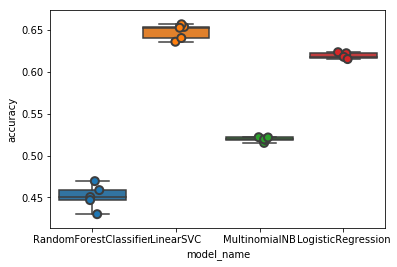

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.648075
LogisticRegression        0.619311
MultinomialNB             0.519385
RandomForestClassifier    0.451059
Name: accuracy, dtype: float64

#### Model Evaluation Example

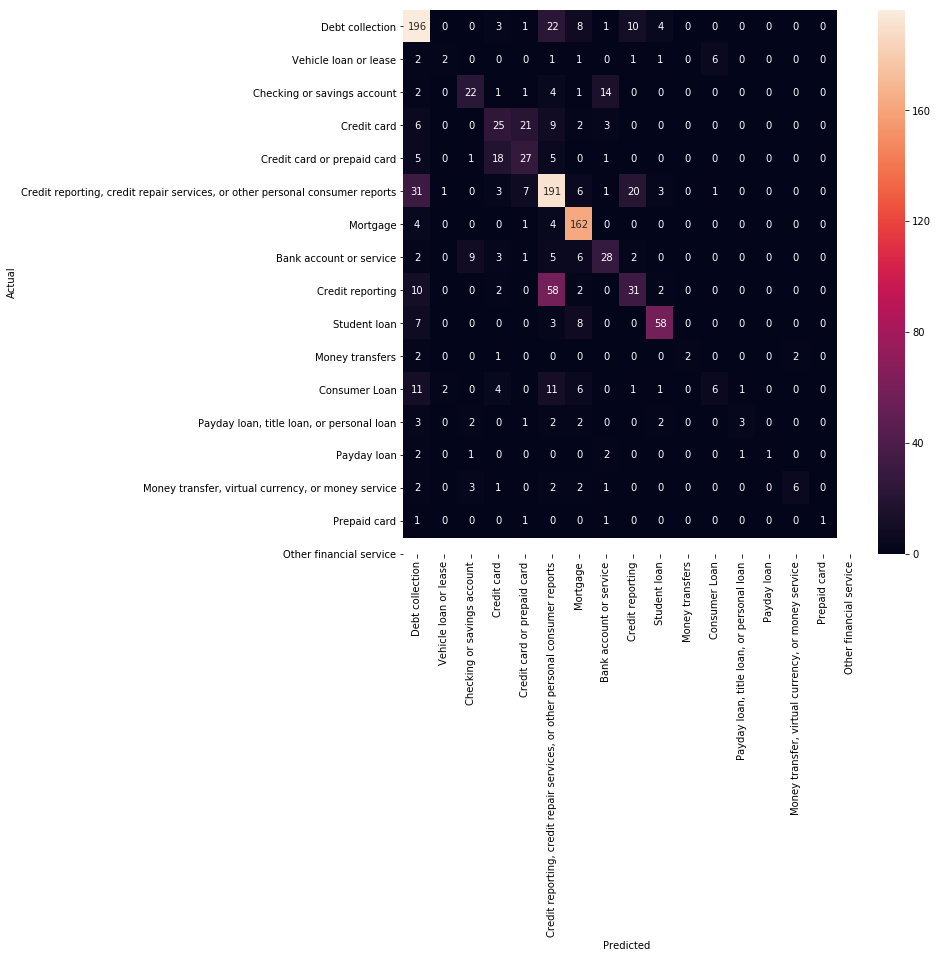

In [17]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### For each category the code identifies the features that best separate the data.

In [18]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . overdraft
  . Top bigrams:
       . xx 2016
       . account wells
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . deposit
  . Top bigrams:
       . access account
       . 60 days
# 'Consumer Loan':
  . Top unigrams:
       . honda
       . auto
  . Top bigrams:
       . auto finance
       . vehicle xxxx
# 'Credit card':
  . Top unigrams:
       . card
       . macys
  . Top bigrams:
       . credit card
       . card services
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . store
  . Top bigrams:
       . card xx
       . credit limit
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . xxxx years
       . removed credit
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . information
       . freeze
  . Top bigrams:
       . xxxx xxxx
       . xxxx experian
# '

In [22]:
from sklearn import metrics
#print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))